#Modelo Preditivo
##Prever fechamento da base diariamente

###Captura e tratamento dos dados

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

In [3]:
df_20anos = pd.read_csv('/content/Dados Históricos - Ibovespa 2004-2024.csv', parse_dates=[0], dayfirst=True, index_col='Data')
df_20anos.sort_index(inplace=True)
df_20anos.index = pd.to_datetime(df_20anos.index)
df_20anos = df_20anos.asfreq('B')

df_20anos

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2004-01-02,22.445,22.233,22.450,22.208,"136,42M","0,94%"
2004-01-05,23.532,22.445,23.532,22.445,"496,71M","4,84%"
2004-01-06,23.576,23.532,23.976,23.180,"472,38M","0,19%"
2004-01-07,23.320,23.576,23.899,23.320,"464,08M","-1,09%"
2004-01-08,23.717,23.334,23.718,23.122,"436,74M","1,70%"
...,...,...,...,...,...,...
2024-03-06,128.890,128.099,129.323,128.099,"11,06M","0,62%"
2024-03-07,128.340,128.890,129.188,128.033,"7,35M","-0,43%"
2024-03-08,127.071,128.335,128.338,125.802,"11,94M","-0,99%"


In [4]:
# df = pd.read_csv('/content/Dados Históricos - Ibovespa 2022-2024.csv', parse_dates=[0])
# df

In [5]:
# df.info()

In [6]:
df_20anos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5268 entries, 2004-01-02 to 2024-03-12
Freq: B
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5000 non-null   float64
 1   Abertura  5000 non-null   float64
 2   Máxima    5000 non-null   float64
 3   Mínima    5000 non-null   float64
 4   Vol.      4999 non-null   object 
 5   Var%      5000 non-null   object 
dtypes: float64(4), object(2)
memory usage: 288.1+ KB


In [7]:
def AjustaVolume(value):
    if isinstance(value, str):
        if 'B' in value:
            return float(value.replace('B', '').replace(',', '.')) * 1_000_000_000
        elif 'M' in value:
            return float(value.replace('M', '').replace(',', '.')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '').replace(',', '.')) * 1_000
        elif ',' in value:
            return float(value.replace(',', '.'))
    return value

In [8]:
def AjustaPorcentagem(value):
    if isinstance(value, str):
      if '%' in value:
          return float(value.replace('%', '').replace(',', '.')) * 1
      elif ',' in value:
          return float(value.replace(',', '.'))
    return value

In [9]:
# df["Vol."] = df["Vol."].apply(AjustaVolume)
# df["Var%"] = df["Var%"].apply(AjustaPorcentagem)
df_20anos["Vol."] = df_20anos["Vol."].apply(AjustaVolume)
df_20anos["Var%"] = df_20anos["Var%"].apply(AjustaPorcentagem)

In [10]:
# df.info()

In [11]:
df_20anos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5268 entries, 2004-01-02 to 2024-03-12
Freq: B
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5000 non-null   float64
 1   Abertura  5000 non-null   float64
 2   Máxima    5000 non-null   float64
 3   Mínima    5000 non-null   float64
 4   Vol.      4999 non-null   float64
 5   Var%      5000 non-null   float64
dtypes: float64(6)
memory usage: 288.1 KB


###Análise Exploratória

In [12]:
df_20anos.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2004-01-02,22.445,22.233,22.450,22.208,136420000.0,0.94
2004-01-05,23.532,22.445,23.532,22.445,496710000.0,4.84
2004-01-06,23.576,23.532,23.976,23.180,472380000.0,0.19
2004-01-07,23.320,23.576,23.899,23.320,464080000.0,-1.09
2004-01-08,23.717,23.334,23.718,23.122,436740000.0,1.70


In [13]:
# df = df.sort_values('Data')
# df.head()

In [14]:
# df.tail()

In [15]:
# df.shape

In [16]:
# df.duplicated().sum()

In [17]:
# df.describe()

In [18]:
# df_anual = df.groupby(df['Data'].dt.year).mean()
# df_anual

In [19]:
# df_mensal = df.groupby(df['Data'].dt.month)[['Último',	'Abertura',	'Máxima',	'Mínima',	'Vol.',	'Var%']].mean()
# df_mensal

In [20]:
# df_ano_mes = df.groupby([df['Data'].dt.year, df['Data'].dt.month])[['Último',	'Abertura',	'Máxima',	'Mínima',	'Vol.',	'Var%']].mean()
# df_ano_mes.index.set_names(['Ano', 'Mês'], inplace=True)
# df_ano_mes['anomes'] = df_ano_mes.index.get_level_values('Ano').astype(str) + df_ano_mes.index.get_level_values('Mês').astype(str).str.zfill(2)

# df_ano_mes

###Visualização dos dados 2 anos

In [21]:
# plt.figure(figsize=(10, 5))
# plt.plot(df['Data'], df['Vol.'])

# plt.title('Evoluçao Volume')
# plt.xlabel('Data')
# plt.ylabel('Volume')

# plt.xticks(rotation=45)

# plt.show()

In [22]:
# plt.figure(figsize=(10, 5))
# plt.plot(df['Data'], df['Último'])

# plt.title('Evoluçao Fechamento')
# plt.xlabel('Data')
# plt.ylabel('Último')

# plt.xticks(rotation=45)

# plt.show()

In [23]:
# plt.figure(figsize=(12, 5))
# plt.plot(df['Data'], df['Var%'])

# plt.title('Evoluçao Variação')
# plt.xlabel('Data')
# plt.ylabel('Variação')

# plt.xticks(rotation=45)

# plt.show()

In [24]:
# Dados_2024 = df.query('Data >= "2024-01-01"')
# Dados_2024.head()

In [25]:
# plt.figure(figsize=(10, 5))
# plt.plot(Dados_2024['Data'], Dados_2024['Último'])
# plt.plot(Dados_2024['Data'], Dados_2024['Abertura'])

# plt.title('Evoluçao Fechamento')
# plt.xlabel('Data')
# plt.ylabel('Último')

# plt.xticks(rotation=45)

# plt.show()

In [26]:
# # Plotar o gráfico
# plt.figure(figsize=(12, 6))

# # Plotar cada coluna
# plt.plot(df_ano_mes['anomes'], df_ano_mes['Último'])

# # Adicionar informações ao gráfico
# plt.title('Médias Mensais de Fechamento')
# plt.xlabel('Ano Mês')
# plt.ylabel('Valor')

# plt.xticks(rotation=45)

# # Mostrar o gráfico
# plt.show()

In [27]:
# # Plotar o gráfico de autocorrelação
# plt.figure(figsize=(10, 6))
# plot_acf(df['Último'], lags=10)
# plt.title('Gráfico de Autocorrelação (ACF)')
# plt.xlabel('Lags')
# plt.ylabel('Autocorrelação')
# plt.show()

###Visualização dos dados 20 anos

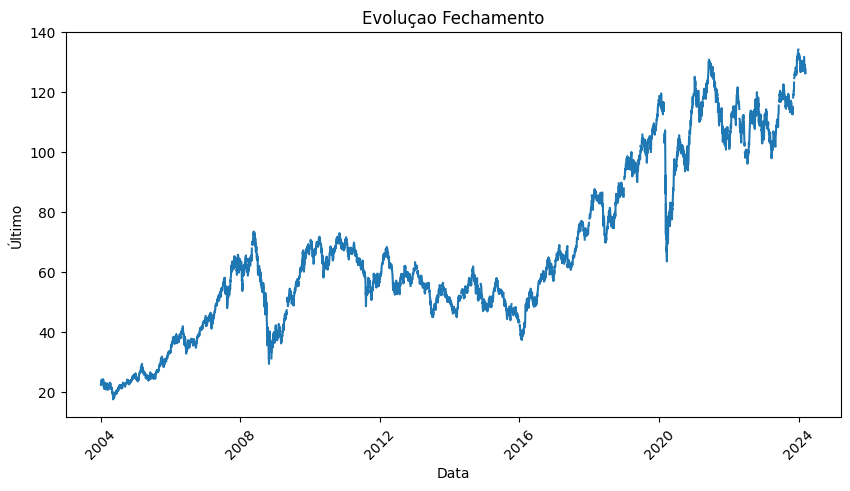

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(df_20anos['Último'])

plt.title('Evoluçao Fechamento')
plt.xlabel('Data')
plt.ylabel('Último')

plt.xticks(rotation=45)

plt.show()

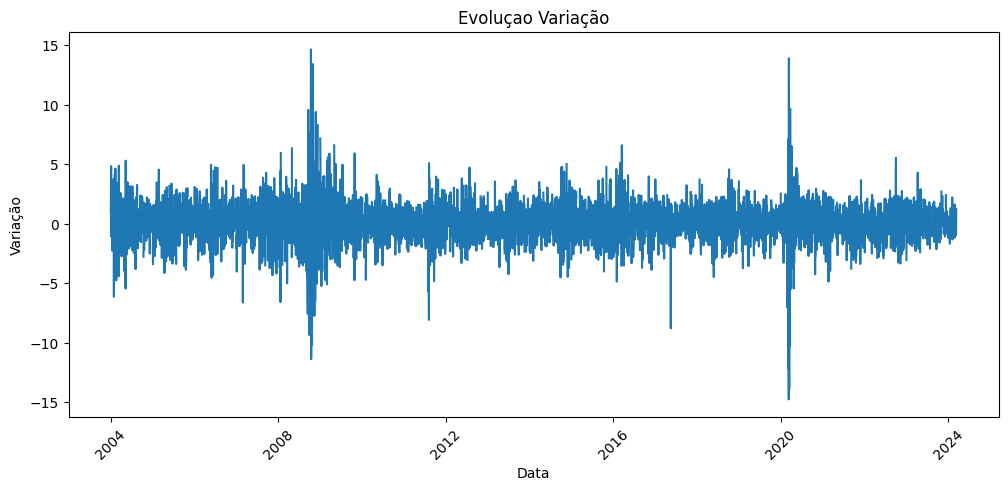

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(df_20anos['Var%'])

plt.title('Evoluçao Variação')
plt.xlabel('Data')
plt.ylabel('Variação')

plt.xticks(rotation=45)

plt.show()

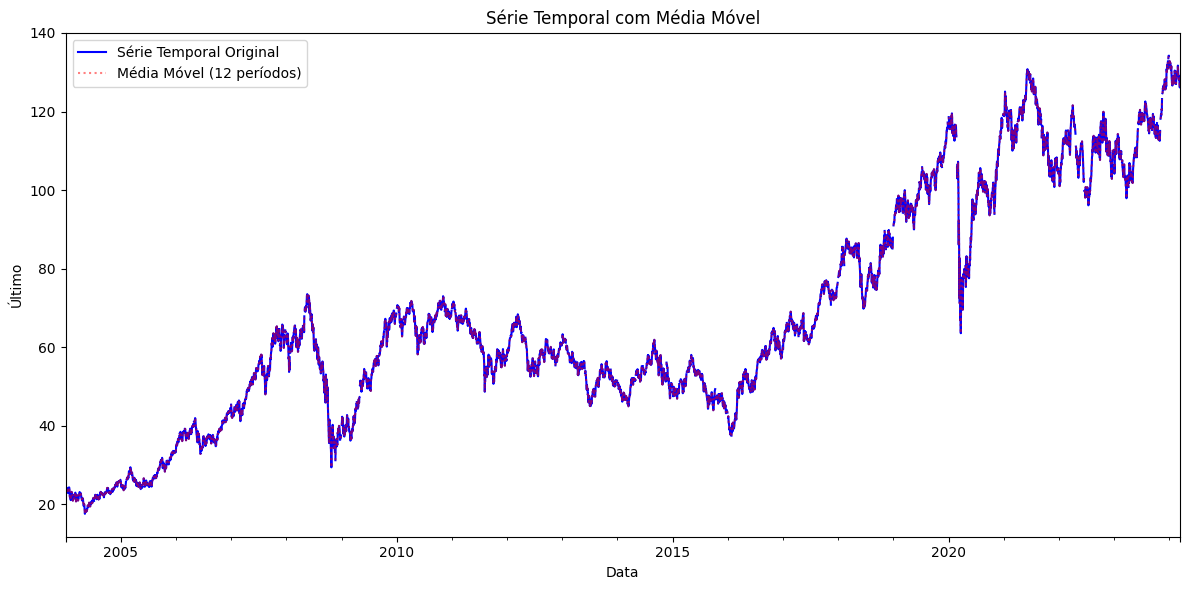

In [30]:
# Definir a coluna 'Data' como índice
df_ma = df_20anos['Último']

# Calcular a média móvel com uma janela de 1 períodos
ma = df_ma.rolling(window=1).mean()

# Plotar a série temporal original e a média móvel
f, ax = plt.subplots(figsize=(12, 6))  # Definir o tamanho da figura
df_ma.plot(ax=ax, legend=True, color='blue', label='Série Temporal Original')
ma.plot(ax=ax, legend=True, color='red', label='Média Móvel (12 períodos)', alpha=0.5, linestyle='dotted')

# Adicionar legendas e título ao gráfico
ax.set_title('Série Temporal com Média Móvel')
ax.set_xlabel('Data')
ax.set_ylabel('Último')
ax.legend(['Série Temporal Original', 'Média Móvel (12 períodos)'])

# Ajustar o layout do gráfico
plt.tight_layout()
plt.show()

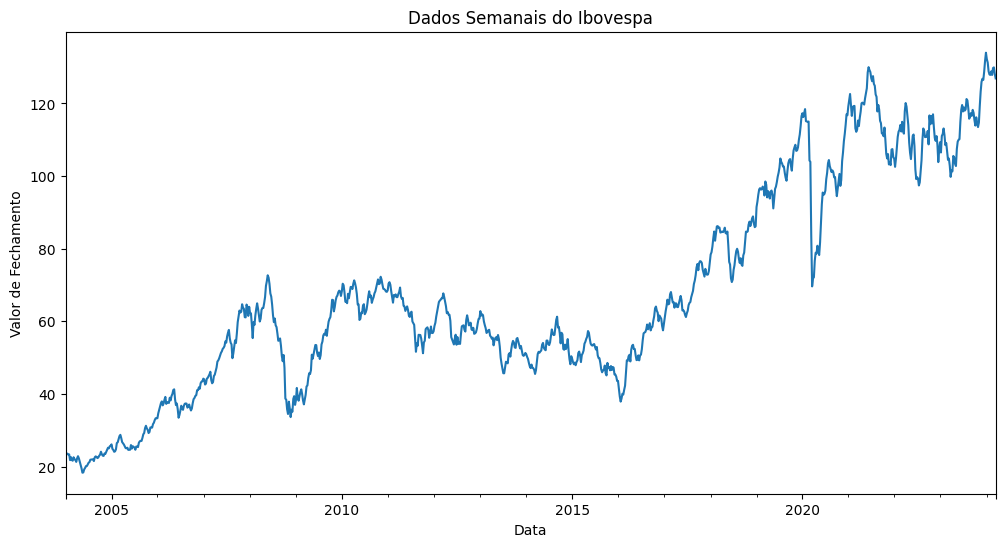

In [31]:
# Agregar dados por semana
weekly_data = df_20anos['Último'].resample('W').mean()

# Plotar dados semanais
weekly_data.plot(title='Dados Semanais do Ibovespa', figsize=(12, 6))
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.show()


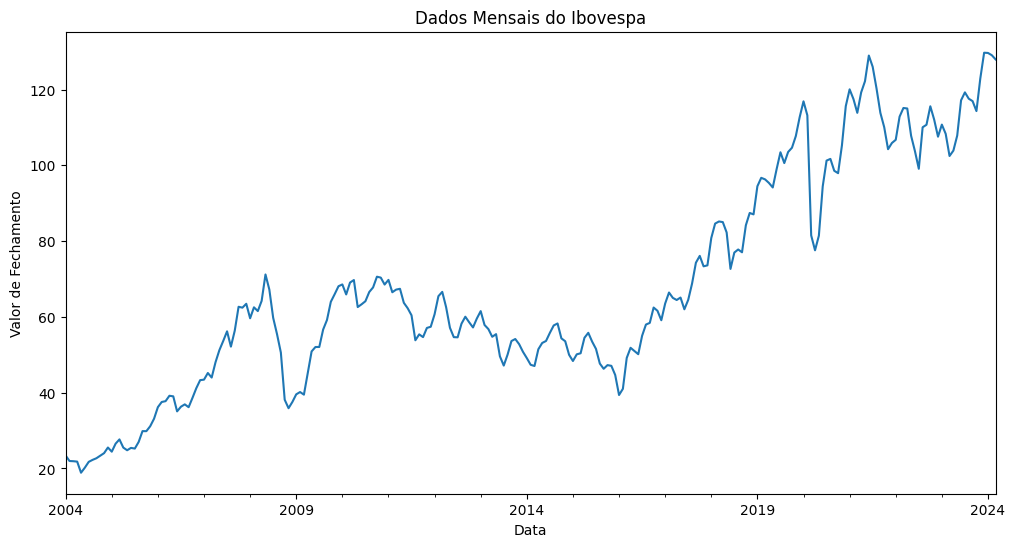

In [32]:
# Agregar dados por semana
weekly_data = df_20anos['Último'].resample('M').mean()

# Plotar dados semanais
weekly_data.plot(title='Dados Mensais do Ibovespa', figsize=(12, 6))
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.show()

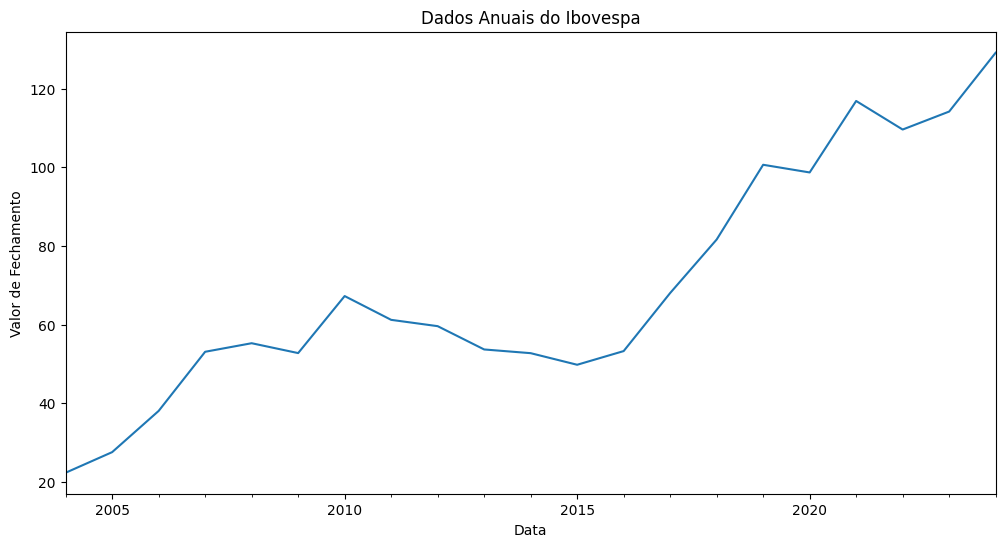

In [33]:
# Agregar dados por semana
weekly_data = df_20anos['Último'].resample('Y').mean()

# Plotar dados semanais
weekly_data.plot(title='Dados Anuais do Ibovespa', figsize=(12, 6))
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.show()

In [34]:
df = df_20anos[['Último']]
df

,Último
Data,
2004-01-02,22.445
2004-01-05,23.532
2004-01-06,23.576
2004-01-07,23.320
2004-01-08,23.717
...,...
2024-03-06,128.890
2024-03-07,128.340
2024-03-08,127.071


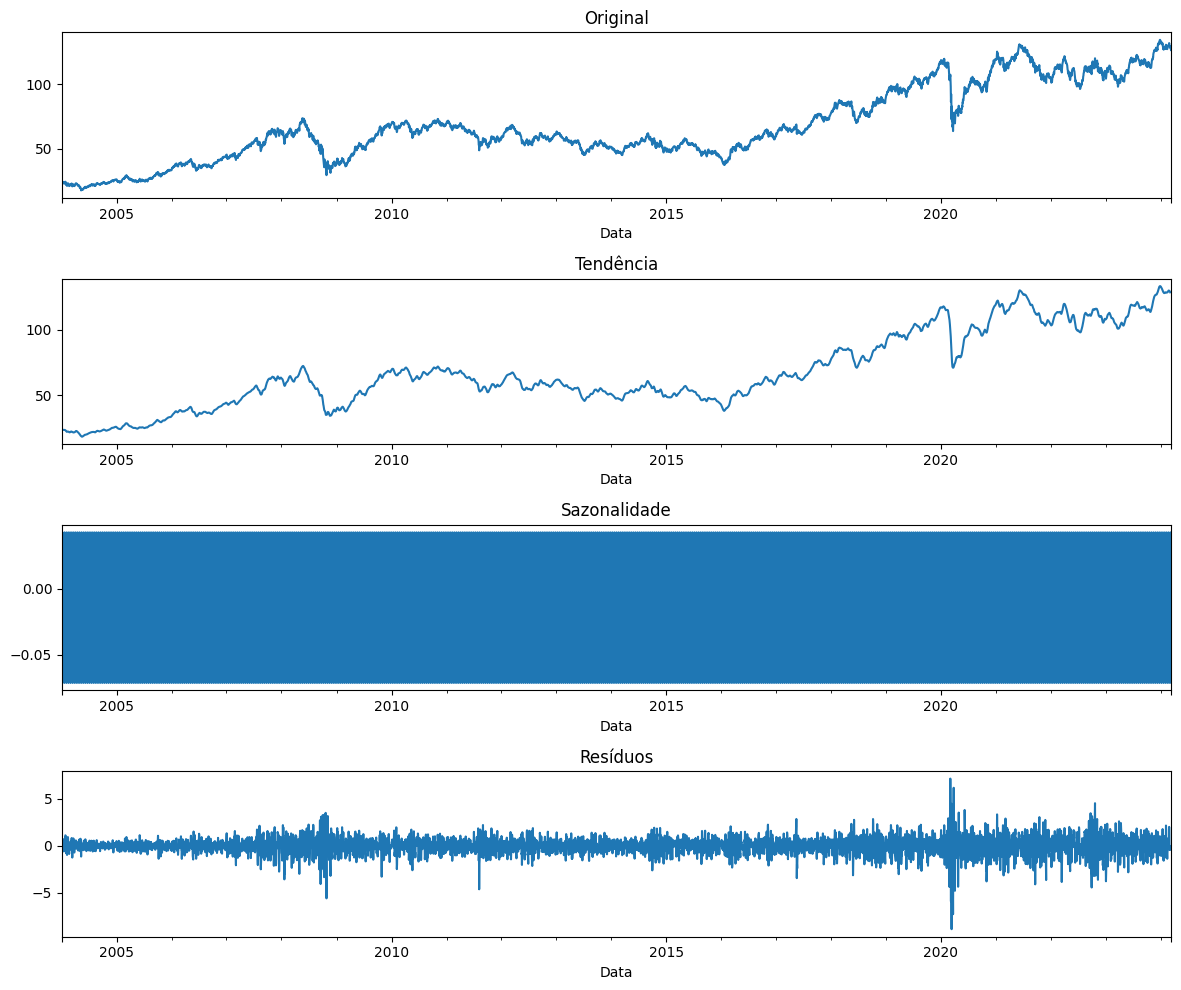

In [35]:

df = df.interpolate()

period = 10
resultados = seasonal_decompose(df, model='additive', period=period)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

resultados.observed.plot(ax=ax1)
ax1.set_title('Original')

resultados.trend.plot(ax=ax2)
ax2.set_title('Tendência')

resultados.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')

resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduos')

plt.tight_layout()
plt.show()

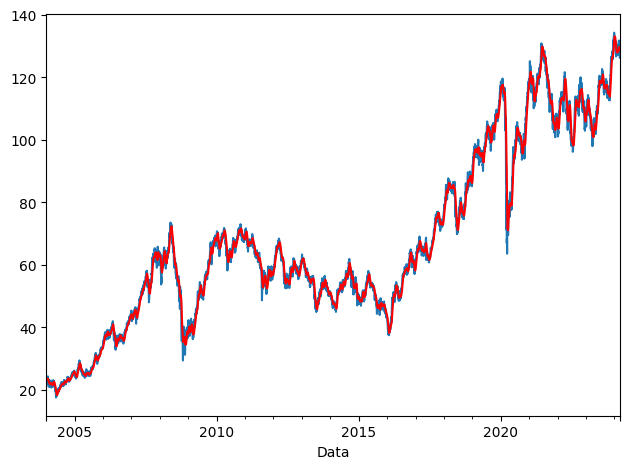

In [36]:
ma = df.rolling(12).mean()

f, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

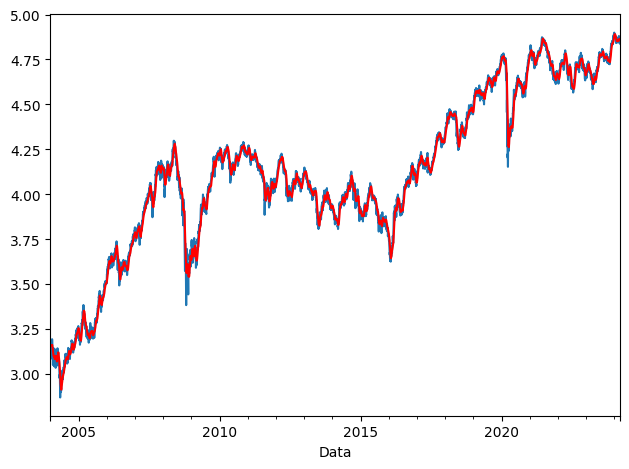

In [37]:
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

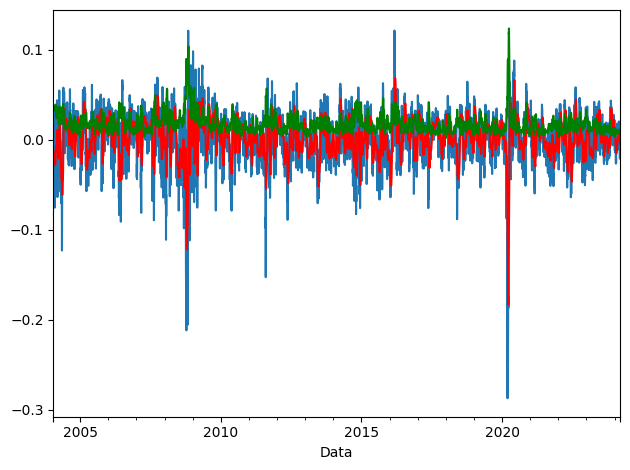

In [38]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


####Convertendo em Estacionária

Teste ADF
Teste Estatístico: -19.151677305520693
P-Value: 0.0
Valores críticos:
	1%: -3.431602875792823
	5%: -2.862093640802141
	10%: -2.567064702779875


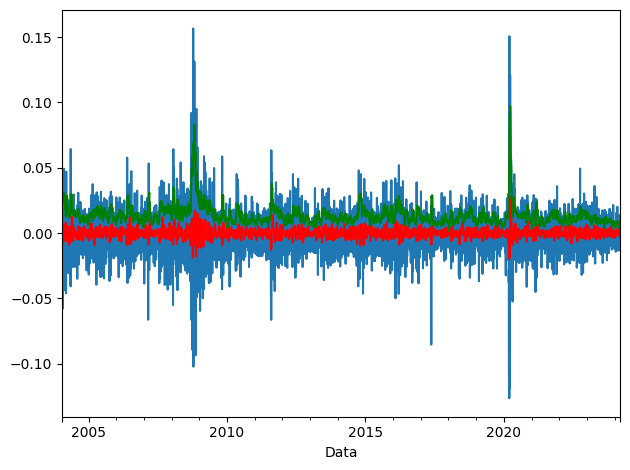

In [39]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()


f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.Último.dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

Diferenciando

In [40]:
df_20anos['diff'] = df_20anos['Último'].diff().dropna()

In [41]:
addresult_diff = adfuller(df_20anos['diff'].dropna())

p = addresult_diff[1]

print(f"P-Value: {p}")

P-Value: 3.7172881471361496e-24


<Axes: xlabel='Data'>

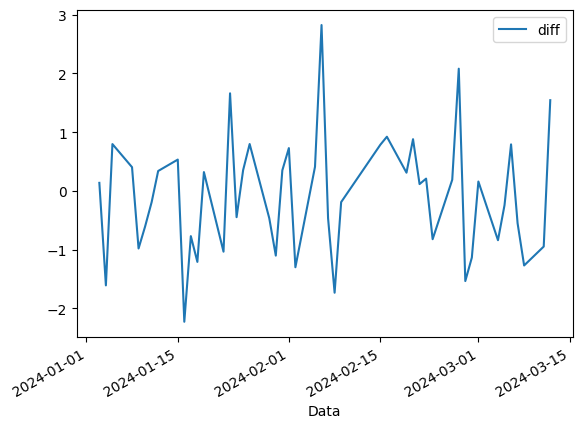

In [42]:
df_diff = df_20anos[['diff']].dropna()
df_diff_2024 = df_diff.query('Data >= "2024-01-01"')
df_diff_2024.plot()

In [43]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

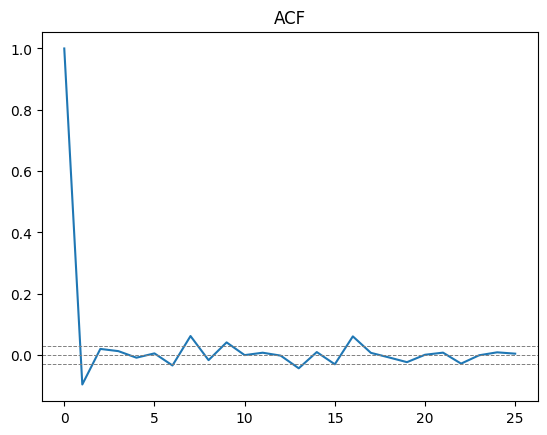

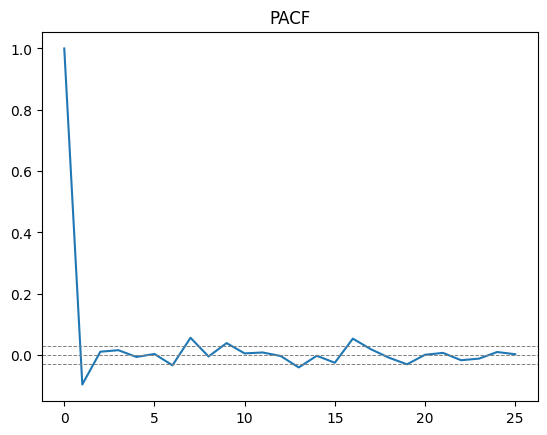

In [44]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()

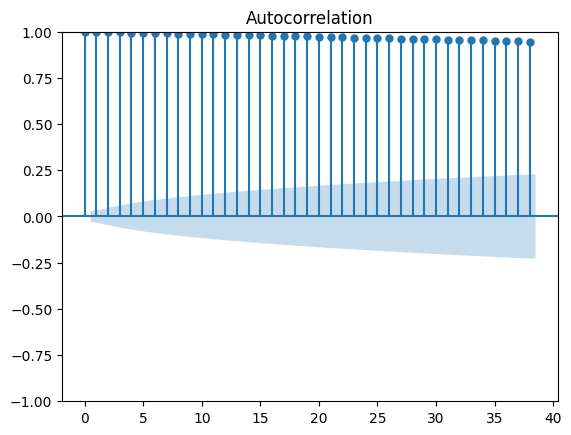

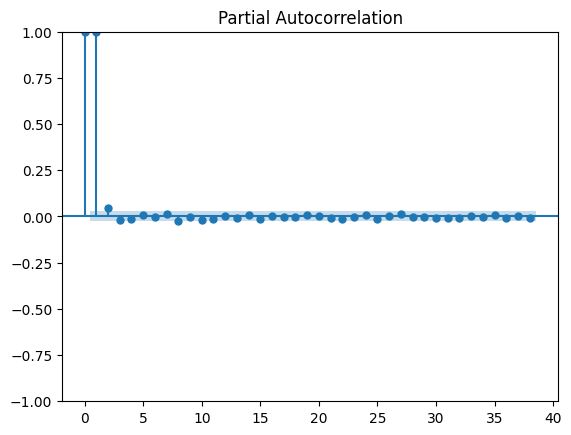

In [45]:
plot_acf(df.Último)
plot_pacf(df.Último)
plt.show()

In [46]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [47]:
adf_test(df_20anos['diff'])

ADF Statistic: -12.930035
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


####Separando dados

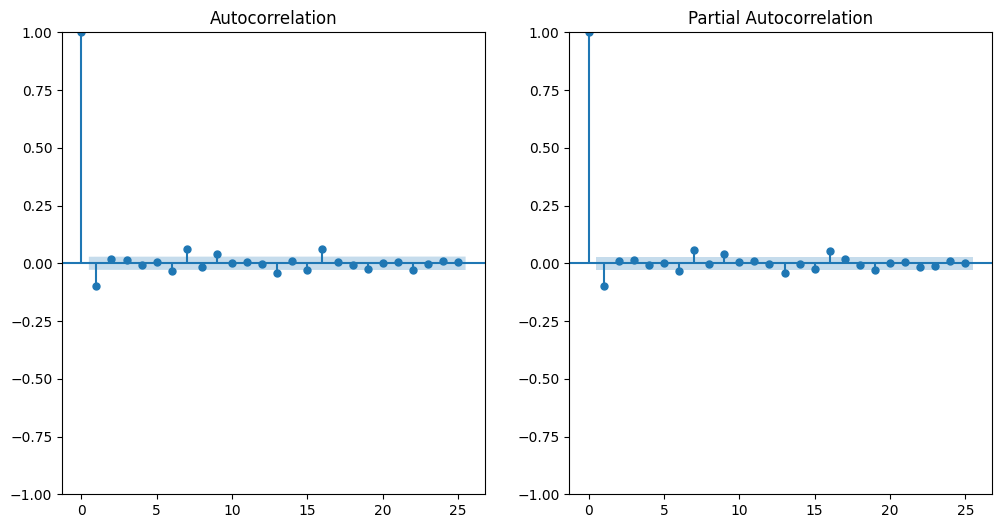

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF e PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_20anos['Último'].diff().dropna(), lags=25, ax=plt.gca())
plt.subplot(122)
plot_pacf(df_20anos['Último'].diff().dropna(), lags=25, ax=plt.gca())
plt.show()

In [49]:
train_size = int(len(df_20anos) * 0.99)
train, test = df_20anos[['diff']].iloc[:train_size].dropna(), df_20anos[['diff']].iloc[train_size:].dropna()

train = train.asfreq('B')
test = test.asfreq('B')

h = test.index.nunique()

In [50]:
h

50

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5214 entries, 2004-01-05 to 2023-12-28
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diff    4729 non-null   float64
dtypes: float64(1)
memory usage: 81.5 KB


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2024-01-03 to 2024-03-12
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diff    47 non-null     float64
dtypes: float64(1)
memory usage: 2.8 KB


In [53]:
train.head()

,diff
Data,
2004-01-05,1.087
2004-01-06,0.044
2004-01-07,-0.256
2004-01-08,0.397
2004-01-09,0.200


In [54]:
test.head()

,diff
Data,
2024-01-03,0.137
2024-01-04,-1.608
2024-01-05,0.797
2024-01-08,0.404
2024-01-09,-0.980


In [55]:
# pip install pmdarima

In [56]:
# from pmdarima import auto_arima

# model = auto_arima(df_20anos['Último'].dropna(), seasonal=True, trace=True)
# print(model.summary())

In [57]:
# model = ARIMA(df_diff_2024.dropna(), order=(0, 1, 0))
# model_fit = model.fit()

In [58]:
# model_fit.forecast(1)

In [59]:
# model = ARIMA(train.dropna(), order=(0, 1, 0))
# model_fit = model.fit()

# forecast = model_fit.forecast(steps=len(test))
# forecast = pd.Series(forecast, index=test.index)

# plt.figure(figsize=(12, 6))
# plt.plot(train.dropna(), label='Treino')
# plt.plot(test.dropna(), label='Teste')
# plt.plot(forecast.dropna(), label='Previsão', color='red')

# plt.legend()
# plt.show()


In [60]:
# model_a = StatsForecast(models=[AutoARIMA(season_length=360)], freq='B', n_jobs=-1)
# model_a.fit(treino)

# # Fazer previsões
# forecast_dfa = model_a.predict(h=h, level=[90])

In [61]:
# forecast_dfa

In [62]:
# # Converter forecast_dfa para DataFrame
# forecast_df = forecast_dfa[['ds', 'AutoARIMA', 'AutoARIMA-lo-90', 'AutoARIMA-hi-90']]

# # Plotar os valores de treino, teste e previsão
# plt.figure(figsize=(12, 6))

# # Plot treino
# plt.plot(treino['ds'], treino['y'], label='Train', color='blue')

# # Plot teste
# plt.plot(teste['ds'], teste['y'], label='Test', color='green')

# # Plot forecast
# plt.plot(forecast_df['ds'], forecast_df['AutoARIMA'], label='Forecast', color='red', linestyle='dashed')

# # Plot intervalo de confiança
# plt.fill_between(forecast_df['ds'],
#                  forecast_df['AutoARIMA-lo-90'],
#                  forecast_df['AutoARIMA-hi-90'],
#                  color='red', alpha=0.3)

# # Adicionar título e legendas
# plt.title('Treino, Teste e Previsão com Intervalo de Confiança')
# plt.xlabel('Data')
# plt.ylabel('Valor')
# plt.legend()

# # Mostrar o plot
# plt.show()

In [63]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

In [64]:
# df_20anos.reset_index(drop=False, inplace=True)
# df_20anos

In [65]:
# train_size = int(len(df_20anos) * 0.7)
# train, test = df_20anos[['Último', 'Data']].iloc[:train_size], df_20anos[['Último', 'Data']].iloc[train_size:]

# train = train.asfreq('D').reset_index(drop=True)
# test = test.asfreq('D').reset_index(drop=True)


# treino = train.rename(columns={'Último': 'y', 'Data': 'ds'})
# treino['unique_id'] = 'serie_1'

# treino['y'] = treino['y'].ffill()

# teste = test.rename(columns={'Último': 'y', 'Data': 'ds'})
# teste['unique_id'] = 'serie_1'

# teste['y'] = teste['y'].ffill()
# h = teste.index.nunique()

# model_s = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
# model_s.fit(treino)

# forecast_dfs = model_s.predict(h=h, level=[90])
# forecast_dfs = forecast_dfs.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')

# model_s.plot(treino, forecast_dfs, level=[90], unique_ids=['serie_1'],engine ='matplotlib', max_insample_length=90)

In [66]:
# train

In [67]:
# treino_plot = treino.iloc[len(treino) - 100:].reset_index(drop=True)
# treino_plot

In [68]:
# forecast_dfs

In [69]:
# plt.plot(treino_plot['ds'], treino_plot['y'], label='treino', color='blue')

# # Plotar dados de teste
# plt.plot(teste['ds'], teste['y'], label='Teste', color='green')

# # Plotar previsões
# forecast_df = forecast_dfs[['ds', 'AutoARIMA', 'AutoARIMA-lo-90', 'AutoARIMA-hi-90']]
# plt.plot(forecast_df['ds'], forecast_df['AutoARIMA'], label='Forecast', color='red', linestyle='dashed')

# # Adicionar intervalo de confiança
# plt.fill_between(forecast_df['ds'],
#                  forecast_df['AutoARIMA-lo-90'],
#                  forecast_df['AutoARIMA-hi-90'],
#                  color='red', alpha=0.3)

# # Adicionar título e legendas
# plt.title('Treino, Teste e Previsão com Modelo AutoARIMA')
# plt.xlabel('Data')
# plt.ylabel('Valor')
# plt.legend()

# # Mostrar o plot
# plt.show()

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [71]:
# forecast_acu = forecast_dfs[['ds', 'AutoARIMA']].rename(columns={'AutoARIMA': 'y_pred'})
# forecast_acu.reset_index(drop=True, inplace=True)
# forecast_acu.dropna()

In [72]:
# teste_acu = teste[['ds', 'y']].rename(columns={'y': 'y_true', 'ds': 'ds'})
# teste_acu.dropna()

In [73]:
# comparison_df = pd.merge(teste_acu, forecast_acu, on='ds', how='left')
# comparison_df = comparison_df.dropna()
# mae = mean_absolute_error(comparison_df['y_true'], comparison_df['y_pred'])
# rmse = np.sqrt(mean_squared_error(comparison_df['y_true'], comparison_df['y_pred']))
# mape = mean_absolute_percentage_error(comparison_df['y_true'], comparison_df['y_pred']) * 100
# r2 = r2_score(comparison_df['y_true'], comparison_df['y_pred'])

# error_margin = 0.05

# comparison_df['error'] = np.abs(comparison_df['y_true'] - comparison_df['y_pred'])
# comparison_df['within_margin'] = comparison_df['error'] <= (error_margin * comparison_df['y_true'])
# accuracy = comparison_df['within_margin'].mean() * 100

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# print(f"R² (Coeficiente de Determinação): {r2:.2f}")
# print(f"Acurácia (Dentro da Faixa de Erro de ±{error_margin*100}%): {accuracy:.2f}%")

In [77]:
treino

,y,unique_id
Data,,
2004-01-05,1.087,serie_1
2004-01-06,0.044,serie_1
2004-01-07,-0.256,serie_1
2004-01-08,0.397,serie_1
2004-01-09,0.200,serie_1
...,...,...
2023-12-22,0.571,serie_1
2023-12-25,0.571,serie_1
2023-12-26,0.571,serie_1


In [78]:
df_20anos = df_20anos.reset_index(drop=False)

In [168]:
teste[:1]

,ds,y,unique_id
5252,2024-02-20,129.916,serie_1


In [169]:
forecast_dfs[:1]

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
serie_1,2024-02-20,129.032547,127.26696,130.798126


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


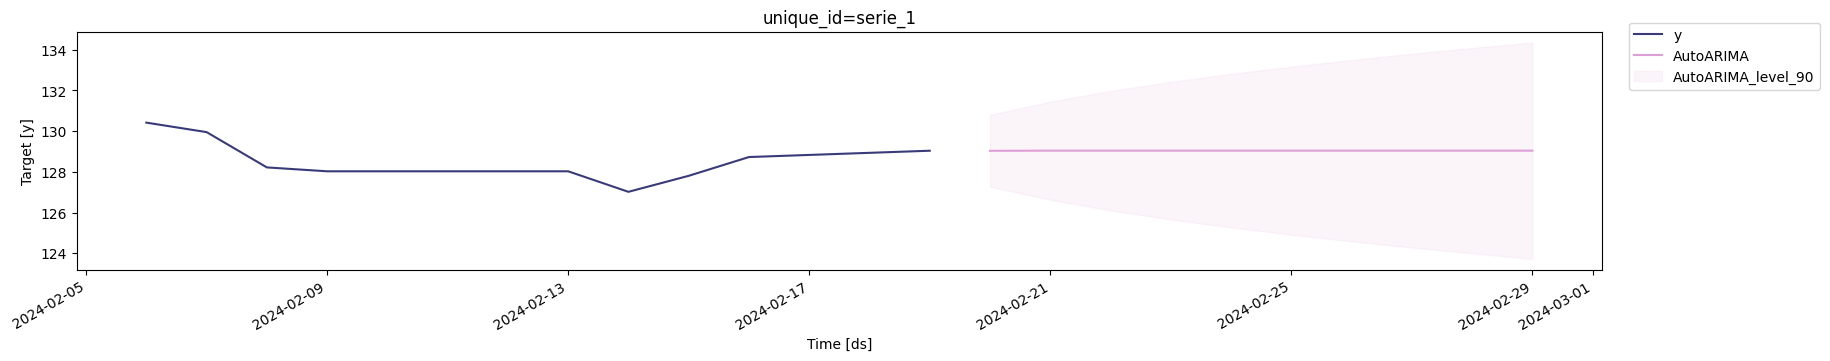

In [151]:
train_size = int(len(df_20anos) * 0.997)
train, test = df_20anos[['Data', 'Último']].iloc[:train_size], df_20anos[['Data', 'Último']].iloc[train_size:]

treino = train.rename(columns={'Último': 'y', 'Data': 'ds'})
treino['unique_id'] = 'serie_1'

treino['y'] = treino['y'].ffill()

teste = test.rename(columns={'Último': 'y', 'Data': 'ds'})
teste['unique_id'] = 'serie_1'

teste['y'] = teste['y'].ffill()

model_s = StatsForecast(models=[AutoARIMA(season_length=30)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=10, level=[90])

model_s.plot(treino, forecast_dfs, level=[90], unique_ids=['serie_1'], engine ='matplotlib', max_insample_length=10)

In [162]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [164]:
forecast_acu = forecast_dfs[['ds', 'AutoARIMA']].rename(columns={'AutoARIMA': 'y_pred'})
forecast_acu.reset_index(drop=True, inplace=True)

teste_acu = teste[['ds', 'y']].rename(columns={'y': 'y_true', 'ds': 'ds'})
teste_acu.dropna()

comparison_df = pd.merge(teste_acu, forecast_acu, on='ds', how='left')
comparison_df = comparison_df.dropna()
mae = mean_absolute_error(comparison_df['y_true'], comparison_df['y_pred'])
rmse = np.sqrt(mean_squared_error(comparison_df['y_true'], comparison_df['y_pred']))
mape = mean_absolute_percentage_error(comparison_df['y_true'], comparison_df['y_pred']) * 100
r2 = r2_score(comparison_df['y_true'], comparison_df['y_pred'])

error_margin = 0.01

comparison_df['error'] = np.abs(comparison_df['y_true'] - comparison_df['y_pred'])
comparison_df['within_margin'] = comparison_df['error'] <= (error_margin * comparison_df['y_true'])
accuracy = comparison_df['within_margin'].mean() * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Acurácia (Dentro da Faixa de Erro de ±{error_margin*100}%): {accuracy:.2f}%")
wmape1 = wmape(comparison_df['y_true'].values, comparison_df['y_pred'].values)
print(f"WMAPE: {wmape1:.2%}")

Mean Absolute Error (MAE): 0.98
Root Mean Squared Error (RMSE): 1.22
Mean Absolute Percentage Error (MAPE): 0.75%
Acurácia (Dentro da Faixa de Erro de ±1.0%): 87.50%
WMAPE: 0.75%


#Modelo ARIMA

In [171]:
model_s

AttributeError: 'StatsForecast' object has no attribute 'export'